<a href="https://colab.research.google.com/github/Alex-Devoid/ST-554-Project1/blob/main/Task3/ST554_Project1_Task3_DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1- Task 3: Time-Series Cross Validation

####Author: Emma Martinez
####Course: ST 554

##Introduction

This notebook evaluates two competing linear regression models for predicting benzene concentration (C6H6) in urban air quality data collected in Italy. Because this is time series data (measurements recorded day-by-day) we cannot use standard cross-validation. Instead, we use a time series cross-validation
approach that takes into account the sequential nature of the data.

We'll clean the dataset, engineer a daily-averaged version, build a Simple Linear Regression (SLR) and a Multiple Linear Regression (MLR) model, evaluate both using our custom CV algorithm, and select the better model.

**Dataset:** UCI Air Quality Dataset (dataset id=360)  
**Response Variable:** C6H6(GT) (Benzene concentration) \
**Predictors:** CO(GT), T, RH, AH

##Install and Import Libraries

In [1]:
# Install the UCI ML repo library
!pip install ucimlrepo

In [2]:
# Import libraries
import ucimlrepo as uci
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

###Libraries Used

- **ucimlrepo**: Imports the Air Quality dataset directly from the UCI ML Repository
- **pandas**: For data manipulation and cleaning
- **numpy**: For numerical operations
- **matplotlib**: For visualizations
- **sklearn.linear_model.LinearRegression**: To fit our regression models
- **sklearn.metrics.mean_squared_error**: To calculate prediction error

##Load the Dataset

In [3]:
# Call in the Air Quality dataset (id=360)
air_quality = uci.fetch_ucirepo(id=360)

# Extract the features DataFrame
df = air_quality.data.features.copy()

# Preview the data
print(df.shape)
df.head()

(9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


### About the Data

The dataset contains hourly air quality measurements from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device in Italy. We see measurements of pollutants (both "true" gold-standard values and sensor readings) as well as weather variables (Temperature, Relative Humidity, Absolute Humidity).

Our task focuses on five variables:
- **C6H6(GT)**: Benzene concentration— response variable (what we're predicting)
- **CO(GT)**: Carbon monoxide concentration— predictor for both models
- **T**: Temperature— predictor for the MLR model
- **RH**: Relative Humidity— predictor for the MLR model
- **AH**: Absolute Humidity— predictor for the MLR model

Values of -200 represent missing data and will be removed.

##Clean the Data

In [4]:
# Double-check column names to ensure correct syntax
print(df.columns.tolist())

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


###Select Variables and Remove Missing Values

In [5]:
# Select only the five variables needed plus the date
cols_needed = ['Date', 'CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
df_clean = df[cols_needed].copy()

# Remove rows where any of the five measurement columns equal -200
measurement_cols = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
df_clean = df_clean[~(df_clean[measurement_cols] == -200).any(axis=1)]

print(f"Rows remaining after removing -200 values: {len(df_clean)}")
df_clean.head()

Rows remaining after removing -200 values: 7344


,Date,CO(GT),C6H6(GT),T,RH,AH
0,3/10/2004,2.6,11.9,13.6,48.9,0.7578
1,3/10/2004,2.0,9.4,13.3,47.7,0.7255
2,3/10/2004,2.2,9.0,11.9,54.0,0.7502
3,3/10/2004,2.2,9.2,11.0,60.0,0.7867
4,3/10/2004,1.6,6.5,11.2,59.6,0.7888


###Create Daily Averages

In [6]:
# Convert Date to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# Group by Date and take the mean of each variable
df_daily = df_clean.groupby('Date')[measurement_cols].mean().reset_index()

print(f"Number of unique dates (rows): {len(df_daily)}")
df_daily.head()

Number of unique dates (rows): 347


,Date,CO(GT),C6H6(GT),T,RH,AH
0,2004-03-10,1.966667,8.450000,12.033333,54.900000,0.765633
1,2004-03-11,2.239130,8.269565,9.826087,64.230435,0.777039
2,2004-03-12,2.804545,12.177273,11.618182,50.190909,0.665164
3,2004-03-13,2.695652,11.121739,13.121739,50.682609,0.733013
4,2004-03-14,2.469565,9.830435,16.182609,48.317391,0.849209


Since the original data is recorded hourly, we collapse it to daily averages for each of our five key variables. This reduces noise and gives us one observation per day. After cleaning and averaging, we have 347 dates (rows) in our dataset (as expected).

In [7]:
# Create a Day variable from 1 to 347
df_daily['Day'] = range(1, len(df_daily) + 1)

print(df_daily[['Date', 'Day']].head(10))
print(f"\nFinal dataset shape: {df_daily.shape}")
df_daily.head()

        Date  Day
0 2004-03-10    1
1 2004-03-11    2
2 2004-03-12    3
3 2004-03-13    4
4 2004-03-14    5
5 2004-03-15    6
6 2004-03-16    7
7 2004-03-17    8
8 2004-03-18    9
9 2004-03-19   10

Final dataset shape: (347, 7)


,Date,CO(GT),C6H6(GT),T,RH,AH,Day
0,2004-03-10,1.966667,8.450000,12.033333,54.900000,0.765633,1
1,2004-03-11,2.239130,8.269565,9.826087,64.230435,0.777039,2
2,2004-03-12,2.804545,12.177273,11.618182,50.190909,0.665164,3
3,2004-03-13,2.695652,11.121739,13.121739,50.682609,0.733013,4
4,2004-03-14,2.469565,9.830435,16.182609,48.317391,0.849209,5


##Exploratory Visualization: Data Over Time

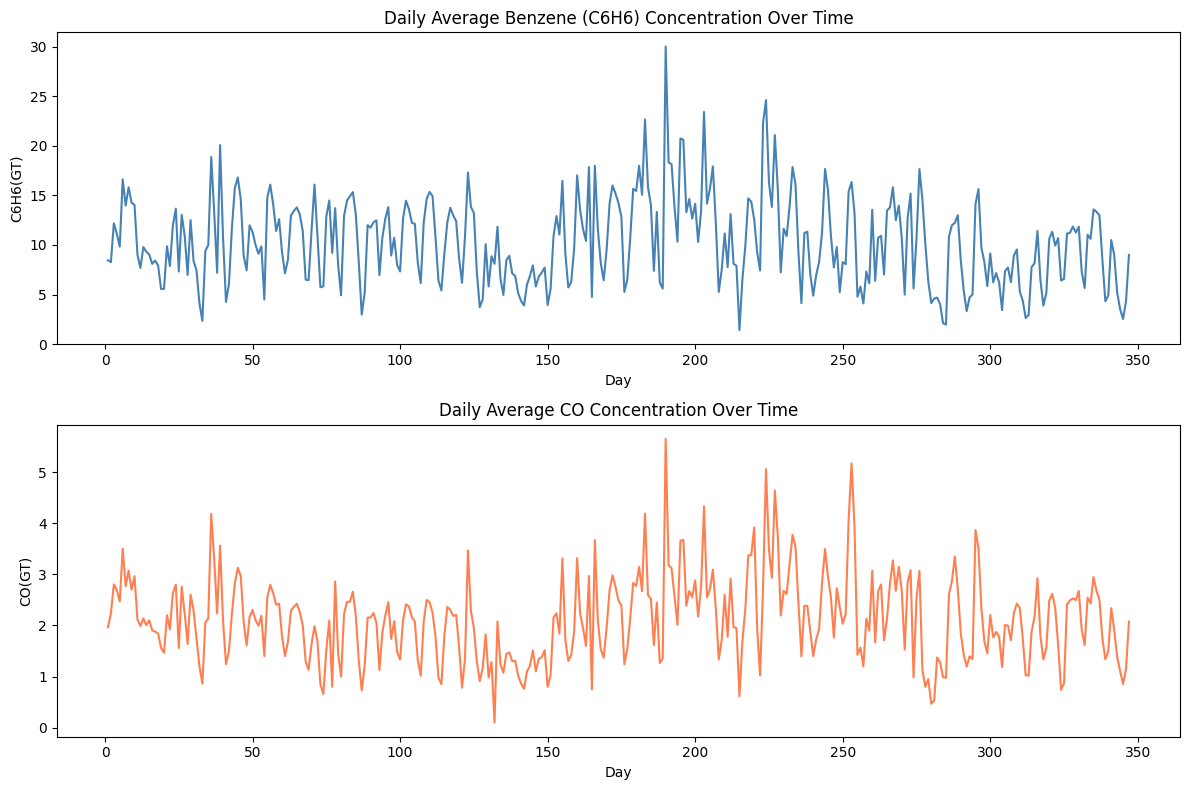

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(df_daily['Day'], df_daily['C6H6(GT)'], color='steelblue')
axes[0].set_title('Daily Average Benzene (C6H6) Concentration Over Time')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('C6H6(GT)')

axes[1].plot(df_daily['Day'], df_daily['CO(GT)'], color='coral')
axes[1].set_title('Daily Average CO Concentration Over Time')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('CO(GT)')

plt.tight_layout()
plt.show()

### Initial Data Exploration

The plots above show how benzene (C6H6) and carbon monoxide (CO) concentrations change over time. We can see temporal trends and fluctuations, which confirms why a time-series-aware cross-validation approach is critical— nearby days tend to be more similar to each other than distant days.

##Define Predictors and Response

In [9]:
# Response variable (what is being predicted)
y = df_daily['C6H6(GT)']

# Predictor for SLR model
X_slr = df_daily[['CO(GT)']]

# Predictors for MLR model
X_mlr = df_daily[['CO(GT)', 'T', 'RH', 'AH']]

print("SLR predictors shape:", X_slr.shape)
print("MLR predictors shape:", X_mlr.shape)
print("Response shape:", y.shape)

SLR predictors shape: (347, 1)
MLR predictors shape: (347, 4)
Response shape: (347,)


### Comparing the Two Models

We'll compare two models:

1. **SLR (Simple Linear Regression):** Uses only CO(GT) to predict C6H6(GT)  

2. **MLR (Multiple Linear Regression):** Uses CO(GT), Temperature, Relative
   Humidity, and Absolute Humidity to predict C6H6(GT)  

Our goal is to answer the question: does adding more predictors actually improve our ability to predict future benzene levels, or is the simpler model sufficient?

##Fit Both Models to the Full Dataset

In [10]:
# Fit SLR to full data
model_slr_full = LinearRegression()
model_slr_full.fit(X_slr, y)
print("SLR Coefficients:")
print(f"  Intercept: {model_slr_full.intercept_:.4f}")
print(f"  CO(GT): {model_slr_full.coef_[0]:.4f}")

# Fit MLR to full data
model_mlr_full = LinearRegression()
model_mlr_full.fit(X_mlr, y)
print("\nMLR Coefficients:")
print(f"  Intercept: {model_mlr_full.intercept_:.4f}")
for name, coef in zip(X_mlr.columns, model_mlr_full.coef_):
    print(f"  {name}: {coef:.4f}")

SLR Coefficients:
  Intercept: 0.6448
  CO(GT): 4.5654

MLR Coefficients:
  Intercept: -1.8378
  CO(GT): 4.7708
  T: 0.1197
  RH: -0.0162
  AH: 0.6887


##Implement the Time Series Cross-Validation

###Time Series Cross-Validation: Important Context

Standard cross-validation randomly splits data for training and testing. This is problematic for time series data because it would allow the model to predict inappropriately during training— data from Day 300 could be used to predict Day 50, which makes no logical sense.

Instead, we'll use time series cross-validation:

1. Train on Days 1–250, predict Day 251
2. Train on Days 1–251, predict Day 252
3. ...continuing through the last day

This mimics real-world prediction: you only use past data to predict the future. We sum up all the MSE values to get an overall cross-validation error for each model.

###Cross-Validation: Helper function

In [11]:
def one_step_mse(X, y, day):
    """
    Fits a linear regression model on all data up to and including 'day',
    then predicts the value for day+1 and returns the MSE for that prediction.

    Parameters:
    -----------
    X : pd.DataFrame
        Predictor variables (all rows, aligned with y)
    y : pd.Series
        Response variable (all rows)
    day : int
        The last day (inclusive) to include in the training set.
        The test point will be day+1.

    Returns:
    --------
    float : MSE for the single test observation (day+1)
    """
    # Use the Day column index logic: Day values are 1-indexed
    # Training: all rows where Day <= day
    # Test: the single row where Day == day + 1

    # Reference the Day column
    day_col = df_daily['Day']

    train_mask = day_col <= day
    test_mask  = day_col == (day + 1)

    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test  = X[test_mask]
    y_test  = y[test_mask]

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate and return MSE
    mse = mean_squared_error(y_test, y_pred)
    return mse

###Cross-Validation: Main Function

In [12]:
def time_series_cv(X, y, day):
    """
    Returns the total MSE across all day+1 predictions,
    starting from the given day and continuing through the dataset.

    Starting from 'day' (i.e, 250), trains on all data up to that day,
    predicts the next day, and repeats until the second-to-last day.
    Accumulates MSE at each step and returns the total.

    Parameters:
    -----------
    X : pd.DataFrame
        Predictor variables
    y : pd.Series
        Response variable
    day : int
        The starting cutoff day (last day of first training window).
        Typically 250 as per the task instructions.

    Returns:
    --------
    float : Total accumulated MSE across all CV steps
    """
    # Determine the final day in the dataset (not hard coded)
    final_day = df_daily['Day'].max()

    # Initialize MSE accumulator
    total_mse = 0

    # Loop from starting day up to (but not including) the final day
    # Stop at final_day - 1 because a "next day" is required to predict
    for d in range(day, final_day):
        total_mse += one_step_mse(X, y, d)

    return total_mse

##Run Cross-Validation on Both Models

In [13]:
# Run time series CV for the SLR model
print("SLR cross-validation:")
cv_mse_slr = time_series_cv(X_slr, y, day=250)
print(f"SLR Total CV MSE: {cv_mse_slr:.4f}")

# Run time series CV for the MLR model
print("MLR cross-validation:")
cv_mse_mlr = time_series_cv(X_mlr, y, day=250)
print(f"MLR Total CV MSE: {cv_mse_mlr:.4f}")

SLR cross-validation:
SLR Total CV MSE: 718.0810
MLR cross-validation:
MLR Total CV MSE: 494.3422


### Results and Model Comparison

| Model | CV MSE |
|-------|--------|
| SLR (CO only) | 718.0810 |
| MLR (CO, T, RH, AH) | 494.3422 |

The MLR model achieves a considerably lower total cross-validation MSE (494.34) compared to the SLR model (718.08)— roughly a 31% reduction in error.

This tells us that temperature, relative humidity, and absolute humidity provide meaningful predictive information about benzene concentration beyond what CO alone can offer. This makes logical sense: weather conditions affect how pollutants disperse and accumulate in the air, so knowing the temperature and humidity on a given day helps us better anticipate benzene levels.

Because our CV approach trained strictly on past data to predict future days, this result gives us a realistic picture of how both models would perform with user input. We have determined the MLR model is superior for this purpose.

##Fit the Best Model to the Full Dataset

In [14]:
# Fit the MLR model (best model) to the entire dataset
best_model = LinearRegression()
best_model.fit(X_mlr, y)

print("MLR Model Coefficients- Full Dataset:")
print(f"  Intercept: {best_model.intercept_:.4f}")
for name, coef in zip(X_mlr.columns, best_model.coef_):
    print(f"  {name}: {coef:.4f}")

MLR Model Coefficients- Full Dataset:
  Intercept: -1.8378
  CO(GT): 4.7708
  T: 0.1197
  RH: -0.0162
  AH: 0.6887


###Final Model / Conclusion

Based on our time series cross-validation results, the MLR model— using CO(GT), temperature, relative humidity, and absolute humidity as predictors— outperformed the SLR model and is our preferred choice. We now fit it to the full 347-day dataset to obtain our best possible coefficient estimates.

Fitting on all available data (rather than just training data) gives us the most precise estimates of each predictor's relationship with benzene concentration, and this is the model we would utilize for future predictions.